# KOMET Project Evaluation Report

![KOMET Project](https://projects.tib.eu/fileadmin/templates/komet/tib_projects_komet_1150.png)

## About KOMET

**KOMET** — *Kollaborative Anreicherung der Metadatenallmende zur Förderung eines diversen Open-Access-Ökosystems* (Collaborative Enrichment of the Metadata Commons to Foster a Diverse Open Access Ecosystem) — enhances metadata processes for independent, scholar-led Open Access journals. The project develops plugins and tools for Open Journal Systems (OJS) to improve article discoverability (https://projects.tib.eu/komet/en/).

KOMET builds on its related project OPTIMETA (https://projects.tib.eu/optimeta/en/) and develops three OJS plugins:

- **PID Plugin**: Integrating validated persistent identifiers (ROR, IGSN, PIDINST, ConfIDent) into article metadata
- **Citations Plugin**: Structured citation metadata capture and publication to the open citation graph via OpenCitations Crowdsourcing (https://github.com/opencitations/crowdsourcing)
- **Geo Plugin**: Geospatial and temporal metadata for location-based article discovery via OPTIMAP (https://optimap.science/)

**Funding**: BMBFTR (German Federal Ministry of Education and Research)  
**Duration**: September 2023 – August 2025  
**Partners**: TIB Hannover (coordinator), TU Dresden

The project outputs are available on GitHub (https://github.com/TIBHannover/optimetaCitations, https://github.com/TIBHannover/optimetaGeo, https://github.com/TIBHannover/optimeta-plugin-shared) and the team communicates via Mastodon (https://openbiblio.social/@komet).

---

## This Notebook: AP 4.3 Evaluation

This notebook implements **Work Package 4.3: Evaluation** from the KOMET project proposal, tracking contributions to the open metadata commons. A [PDF version of this report](komet_report.pdf) is also available.

### Data Sources & Platform Priority

| Source | Purpose | Priority |
|--------|---------|----------|
| **OpenCitations** | Citation metadata contributions | Primary |
| **Wikidata** | Scholarly graph baseline & P2860 citations | Monitoring |
| **OpenAIRE** | Future: citation data exploration | Planned |


In [1]:
# Setup and imports (hidden in HTML export)
import komet_helpers as kh
from datetime import datetime
import json
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import HTML, display, Markdown

# Set matplotlib style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['font.size'] = 11

# Load or create timeline for tracking metrics over time
timeline = kh.load_timeline()
report_timestamp = kh.format_timestamp()

In [2]:
# Table display helper for HTML and PDF export
from IPython.display import display, HTML, Markdown

def show_table(df, caption=None, index=False):
    """
    Display DataFrame as HTML table with optional caption.
    For PDF export via markdown, tables are converted by nbconvert.
    Links in cells should use HTML <a> tags for proper rendering.
    """
    html = df.to_html(escape=False, index=index, classes='dataframe table')
    if caption:
        html = f"<p><strong>{caption}</strong></p>\n{html}"
    display(HTML(html))


In [3]:
# Report metadata
last_updated = timeline["metadata"].get("last_updated", "Never")
last_updated_str = last_updated[:19].replace("T", " ") if last_updated and last_updated != "Never" else "Never"

display(Markdown(f'''
**Report Information**

| Field | Value |
|-------|-------|
| Generated | {report_timestamp[:19].replace("T", " ")} UTC |
| Timeline Version | {timeline["metadata"].get("version", "1.0")} |
| Last Updated | {last_updated_str} UTC |
| Update Frequency | Monthly (1st of each month) |
'''))



<div style="background: #f8f9fa; padding: 15px; border-radius: 8px; margin: 10px 0;">
    <h4 style="margin-top: 0;">Report Information</h4>
    <ul style="margin-bottom: 0;">
        <li><strong>Generated:</strong> 2026-02-01 06:39:18 UTC</li>
        <li><strong>Timeline Version:</strong> 2.0</li>
        <li><strong>Last Updated:</strong> 2026-01-30 15:20:01 UTC</li>
        <li><strong>Update Frequency:</strong> Monthly (1st of each month)</li>
    </ul>
</div>


---

## 1. Wikidata Analysis

### 1.1 P1343 (Described by Source) - Limited Reach

The original KOMET proposal mentioned using **P1343 ("described by source")** to mark contributions from project plugins. However, our analysis reveals this property has **very limited usage** for scholarly articles:

- P1343 is primarily used for encyclopedias/reference works
- It is **NOT** the standard property for citations in Wikidata
- The primary citation property is **P2860 ("cites work")** with ~3.4M relationships
- **Wikidata is no longer the primary target** — OpenCitations is the focus

In [4]:
# Query P1343 usage (hidden - data fetching)
p1343_count = kh.count_p1343_scholarly_articles()
komet_provenance = kh.search_komet_provenance_wikidata()

# Log to timeline
if p1343_count is not None:
    kh.add_observation(
        timeline, "wikidata.p1343_scholarly_count", p1343_count, "wikidata",
        notes="P1343 rarely used for scholarly articles",
        metric_name="P1343 Scholarly Articles",
        metric_description="Scholarly articles with 'described by source' property"
    )

kh.add_observation(
    timeline, "wikidata.komet_provenance_count", len(komet_provenance) if komet_provenance else 0,
    "wikidata", notes="Items with KOMET in P1343 source",
    metric_name="KOMET Provenance Items",
    metric_description="Wikidata items with KOMET as source"
)

Query timed out after 60s


False

In [5]:
# Display P1343 findings
p1343_display = p1343_count if p1343_count is not None else "Query failed"
komet_prov_count = len(komet_provenance) if komet_provenance else 0

display(Markdown(f'''
### P1343 Limitation Finding

| Metric | Value |
|--------|------:|
| Scholarly articles with P1343 | **{p1343_display}** |
| Total scholarly articles in Wikidata | ~37,000,000 |
| Items referencing KOMET as source | {komet_prov_count} |

> **Conclusion:** P1343 is not suitable for tracking KOMET contributions. Focus shifted to OpenCitations.
'''))



### P1343 Limitation Finding

| Metric | Value |
|--------|------:|
| Scholarly articles with P1343 | **14** |
| Total scholarly articles in Wikidata | ~37,000,000 |
| Items referencing KOMET as source | 0 |

> **Conclusion:** P1343 is not suitable for tracking KOMET contributions. Focus shifted to OpenCitations.


### 1.2 P2860 (Cites Work) - Partner Journal Baseline

We track **P2860 (cites work)** relationships for KOMET partner journals to establish a baseline for measuring impact over time.

**Partner Journals Source**: The list of partner journals originates from the related project OPTIMETA (https://projects.tib.eu/optimeta/en/). These are OJS-based journals from academic institutions that have committed to testing the KOMET plugins.

In [6]:
# Fetch partner journal data (hidden - data fetching)
partner_journals = kh.get_journals_with_wikidata()
journal_stats = []

for journal in partner_journals:
    qid = journal["wikidata_qid"]
    name = journal["name"]
    
    article_count = kh.count_journal_articles_wikidata(qid)
    citation_count = kh.count_journal_citations_p2860(qid)
    
    stats = {
        "name": name,
        "partner": journal.get("partner", "Unknown"),
        "qid": qid,
        "wikidata_articles": article_count or 0,
        "wikidata_citations_p2860": citation_count or 0,
        "baseline_2022": journal.get("baseline_2022", {})
    }
    journal_stats.append(stats)
    
    # Log to timeline
    kh.add_journal_observation(timeline, qid, "articles", article_count,
                               journal_name=name, partner=journal.get("partner"))
    kh.add_journal_observation(timeline, qid, "citations_p2860", citation_count,
                               journal_name=name, partner=journal.get("partner"))
    time.sleep(1)  # Rate limiting

# Calculate totals
total_articles = sum(s['wikidata_articles'] for s in journal_stats)
total_citations = sum(s['wikidata_citations_p2860'] for s in journal_stats)

In [7]:
# Display partner journal statistics as interactive table
df_journals = pd.DataFrame([{
    'Journal': s['name'],
    'Partner': s['partner'],
    'Wikidata QID': f'<a href="https://www.wikidata.org/wiki/{s["qid"]}" target="_blank">{s["qid"]}</a>',
    'Articles': s['wikidata_articles'],
    'Citations (P2860)': s['wikidata_citations_p2860']
} for s in journal_stats])

display(Markdown(f'''
#### Partner Journal Wikidata Statistics

**Total journals tracked:** {len(journal_stats)} | **Total articles:** {total_articles} | **Total citations:** {total_citations}
'''))

show_table(df_journals)



#### Partner Journal Wikidata Statistics

**Total journals tracked:** 15 | **Total articles:** 42 | **Total citations:** 2


Loading ITables v2.6.2 from the init_notebook_mode cell... (need help?)


### 1.3 Comparison with 2022 Baseline

The 2022 baseline data allows tracking changes in Wikidata coverage over time.

In [8]:
# Create comparison table
comparison_data = []
for s in journal_stats:
    baseline = s.get('baseline_2022', {})
    baseline_art = baseline.get('wikidata_articles', 0)
    current_art = s['wikidata_articles']
    change = current_art - baseline_art
    
    comparison_data.append({
        'Journal': s['name'][:40] + ('...' if len(s['name']) > 40 else ''),
        '2022 Articles': baseline_art,
        'Current Articles': current_art,
        'Change': f"+{change}" if change >= 0 else str(change),
        'OpenAlex (2022)': baseline.get('openalex', 'N/A')
    })

df_comparison = pd.DataFrame(comparison_data)

display(Markdown('#### 2022 Baseline vs Current Wikidata Coverage'))
show_table(df_comparison)


#### 2022 Baseline vs Current Wikidata Coverage

Loading ITables v2.6.2 from the init_notebook_mode cell... (need help?)


### 1.4 Key Observations & Interpretation

The comparison between Wikidata coverage and OpenAlex data reveals significant insights about the current state of metadata in the open knowledge commons.

In [9]:
# Analyze and display key observations
active_journals = [s for s in journal_stats if s['wikidata_articles'] > 0]
journals_with_citations = [s for s in journal_stats if s['wikidata_citations_p2860'] > 0]

# Find journals with significant OpenAlex but no Wikidata
gap_journals = []
for s in journal_stats:
    baseline = s.get('baseline_2022', {})
    openalex = baseline.get('openalex', 0)
    if openalex and openalex > 100 and s['wikidata_articles'] == 0:
        gap_journals.append({'name': s['name'], 'openalex': openalex, 'wikidata': s['wikidata_articles']})

# Calculate total OpenAlex coverage
total_openalex = sum(s.get('baseline_2022', {}).get('openalex', 0) or 0 for s in journal_stats)
coverage_ratio = (total_articles / total_openalex * 100) if total_openalex > 0 else 0

# Get specific journal stats
info_praxis = next((s for s in journal_stats if s['qid'] == 'Q46478422'), None)
itdb = next((s for s in journal_stats if s['qid'] == 'Q107074231'), None)

# Display key findings using markdown (works in both HTML and PDF)
display(Markdown(f'''
### Key Findings

| Metric | Value |
|--------|-------|
| **Active Journals in Wikidata** | {len(active_journals)} of {len(journal_stats)} journals have articles indexed |
| **Wikidata vs OpenAlex Gap** | {coverage_ratio:.1f}% Wikidata coverage of OpenAlex articles |

**Notable Observations:**

- **Informationspraxis** (Q46478422) leads with {info_praxis['wikidata_articles'] if info_praxis else 0} articles and {info_praxis['wikidata_citations_p2860'] if info_praxis else 0} citation relationships — the only journal with P2860 data
- **itdb** (Q107074231) shows organic growth: {itdb['wikidata_articles'] if itdb else 0} articles (up from 13 in 2022 baseline)
- **{len(gap_journals)} journals** have significant OpenAlex coverage but zero Wikidata presence
'''))



### Key Findings

| Metric | Value |
|--------|-------|
| **Active Journals in Wikidata** | 2 of 15 journals have articles indexed |
| **Wikidata vs OpenAlex Gap** | 0.8% Wikidata coverage of OpenAlex articles |

**Notable Observations:**

- **Informationspraxis** (Q46478422) leads with 28 articles and 2 citation relationships — the only journal with P2860 data
- **itdb** (Q107074231) shows organic growth: 14 articles (up from 13 in 2022 baseline)
- **8 journals** have significant OpenAlex coverage but zero Wikidata presence


In [10]:
# Display the gap analysis table
if gap_journals:
    display(Markdown('''
##### The Metadata Gap: OpenAlex vs Wikidata

These journals have substantial article counts in OpenAlex but are not yet represented in Wikidata:
'''))
    
    gap_df = pd.DataFrame(gap_journals)
    gap_df.columns = ['Journal', 'OpenAlex Articles', 'Wikidata Articles']
    gap_df = gap_df.sort_values('OpenAlex Articles', ascending=False)
    show_table(gap_df)



##### The Metadata Gap: OpenAlex vs Wikidata

These journals have substantial article counts in OpenAlex but are not yet represented in Wikidata:


Journal,OpenAlex Articles,Wikidata Articles
VITIS - Journal of Grapevine Research,1762,0
Francia-Recensio,1096,0
Jahrbuch für Christliche Sozialwissenschaften,850,0
Journal für Kulturpflanzen,558,0
Journal of Applied Botany and Food Quality,419,0
International Journal of Dream Research,352,0
Archäologischer Anzeiger,224,0
Journal of Spatial Information Science,201,0


Loading ITables v2.6.2 from the init_notebook_mode cell... (need help?)


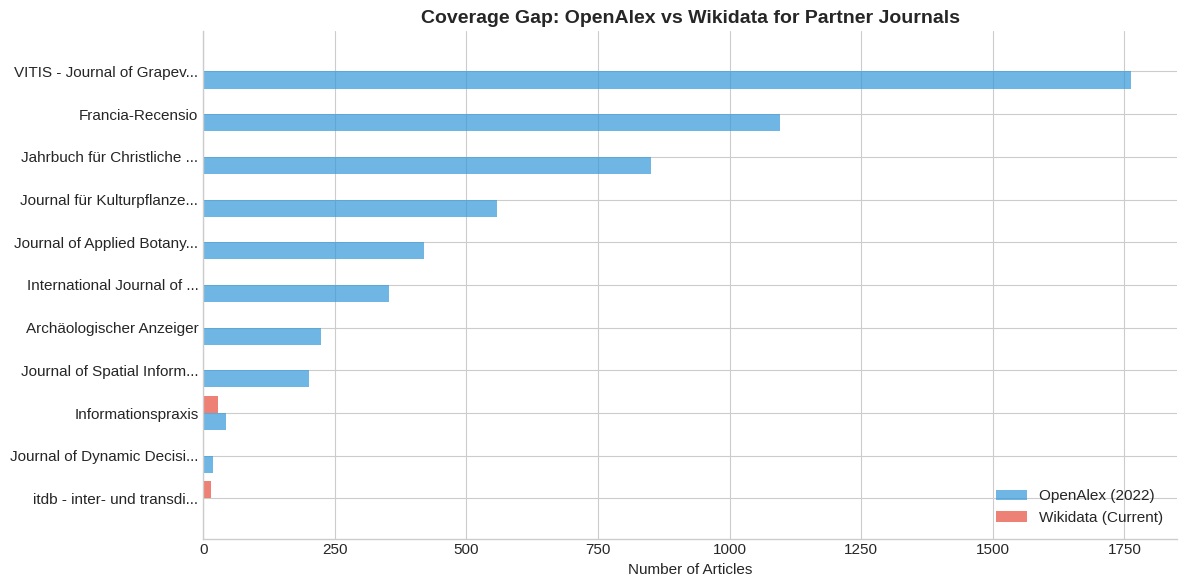

In [11]:
# Visualization: Coverage gap chart
fig, ax = plt.subplots(figsize=(12, 6))

# Prepare data for visualization
viz_data = []
for s in journal_stats:
    baseline = s.get('baseline_2022', {})
    openalex = baseline.get('openalex', 0) or 0
    if openalex > 0 or s['wikidata_articles'] > 0:
        viz_data.append({
            'name': s['name'][:25] + ('...' if len(s['name']) > 25 else ''),
            'openalex': openalex,
            'wikidata': s['wikidata_articles']
        })

viz_df = pd.DataFrame(viz_data).sort_values('openalex', ascending=True)

y_pos = range(len(viz_df))
ax.barh(y_pos, viz_df['openalex'], height=0.4, label='OpenAlex (2022)', color='#3498db', alpha=0.7)
ax.barh([y + 0.4 for y in y_pos], viz_df['wikidata'], height=0.4, label='Wikidata (Current)', color='#e74c3c', alpha=0.7)

ax.set_yticks([y + 0.2 for y in y_pos])
ax.set_yticklabels(viz_df['name'])
ax.set_xlabel('Number of Articles')
ax.set_title('Coverage Gap: OpenAlex vs Wikidata for Partner Journals', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

display(HTML('<p style="font-size: 0.9em; color: #666;"><em>Figure 1: The gap between OpenAlex coverage and Wikidata presence demonstrates the opportunity for KOMET to enrich the metadata commons.</em></p>'))

### 1.5 Interpretation & Implications for KOMET

#### What the Data Shows

The stark contrast between OpenAlex coverage (thousands of articles) and Wikidata presence (near zero for most journals) demonstrates the **metadata gap** that KOMET aims to address. This gap exists because:

1. **No automated pipeline**: Unlike OpenAlex, which aggregates from multiple sources, Wikidata requires explicit contributions
2. **Manual effort barrier**: Adding scholarly articles to Wikidata traditionally requires significant manual work
3. **Tool availability**: Until KOMET plugins, OJS journals lacked easy mechanisms to publish structured metadata

#### Why This Matters

- **Discoverability**: Articles not in open knowledge graphs are harder to find and cite
- **Citation tracking**: Without structured citation data, the impact of independent journals remains invisible
- **Diverse OA ecosystem**: Scholar-led journals are underrepresented in major metadata infrastructures

#### KOMET's Opportunity

The baseline data shows that even minimal intervention can make a difference:
- **Informationspraxis** demonstrates that journals *can* achieve Wikidata presence with effort
- **itdb's growth** (+1 article since 2022) shows organic improvement is possible but slow
- The **5,000+ articles** in OpenAlex from partner journals represent untapped potential for enriching the metadata commons

> **Bottom line**: KOMET plugins can help bridge this gap by automating metadata publication from OJS to open infrastructures like OpenCitations, making the work of independent journals more visible and connected.

---

## 2. OpenCitations Crowdsourcing Analysis

**OpenCitations is the primary target platform** for KOMET citation metadata contributions.

The crowdsourcing repository (https://github.com/opencitations/crowdsourcing) allows trusted agents to contribute citation metadata via GitHub Issues.

In [12]:
# Fetch OpenCitations data (hidden - data fetching)
github_token = os.environ.get('GITHUB_TOKEN')
all_issues = kh.get_all_opencitations_issues(token=github_token)
summary = kh.summarize_opencitations_contributions(all_issues)

# Filter KOMET contributions
komet_issues = kh.filter_komet_contributions(all_issues)
komet_summary = kh.summarize_opencitations_contributions(komet_issues) if komet_issues else {'total_issues': 0, 'status_breakdown': {}}

successful = komet_summary['status_breakdown'].get('done', 0)
pending = komet_summary['status_breakdown'].get('to_be_processed', 0)
invalid = komet_summary['status_breakdown'].get('invalid', 0)

# Log to timeline
kh.add_observation(timeline, "opencitations.total_issues", len(all_issues), "opencitations",
                   metric_name="Total Crowdsourcing Issues")
kh.add_observation(timeline, "opencitations.komet_issues", len(komet_issues), "opencitations",
                   metric_name="KOMET Issues")
kh.add_observation(timeline, "opencitations.komet_done", successful, "opencitations",
                   metric_name="KOMET Successful")
kh.add_observation(timeline, "opencitations.komet_pending", pending, "opencitations",
                   metric_name="KOMET Pending")
kh.add_observation(timeline, "opencitations.komet_invalid", invalid, "opencitations",
                   metric_name="KOMET Invalid")

False

In [13]:
# Display OpenCitations summary
status_breakdown = summary['status_breakdown']

display(Markdown(f'''
### OpenCitations Crowdsourcing Overview

#### All Crowdsourcing Activity

**Total submissions: {summary["total_issues"]}**

| Status | Count |
|--------|------:|
''' + '\n'.join([f'| {status} | {count} |' for status, count in sorted(status_breakdown.items(), key=lambda x: -x[1])]) + f'''

#### KOMET Contributions

**Total KOMET submissions: {komet_summary["total_issues"]}**

| Status | Count |
|--------|------:|
| Successful | {successful} |
| Pending | {pending} |
| Invalid | {invalid} |
'''))



### OpenCitations Crowdsourcing Overview

#### All Crowdsourcing Activity

**Total submissions: 15**

| Status | Count |
|--------|------:|
| invalid | 11 |
| unknown | 2 |
| done | 1 |
| to_be_processed | 1 |

#### KOMET Contributions

**Total KOMET submissions: 4**

| Status | Count |
|--------|------:|
| Successful | 0 |
| Pending | 0 |
| Invalid | 4 |


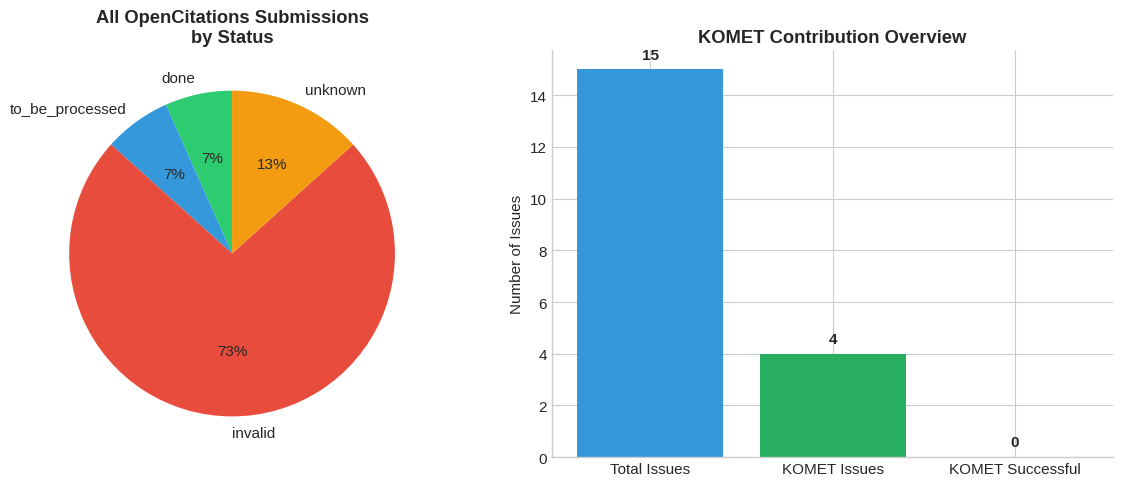

In [14]:
# Visualization: OpenCitations status breakdown
if summary['status_breakdown']:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Pie chart for all issues
    statuses = list(summary['status_breakdown'].keys())
    counts = list(summary['status_breakdown'].values())
    colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12', '#9b59b6']
    
    ax1.pie(counts, labels=statuses, autopct='%1.0f%%', colors=colors[:len(statuses)], startangle=90)
    ax1.set_title('All OpenCitations Submissions\nby Status', fontweight='bold')
    
    # Bar chart for KOMET vs total
    categories = ['Total Issues', 'KOMET Issues', 'KOMET Successful']
    values = [summary['total_issues'], komet_summary['total_issues'], successful]
    bar_colors = ['#3498db', '#27ae60', '#2ecc71']
    
    bars = ax2.bar(categories, values, color=bar_colors)
    ax2.set_ylabel('Number of Issues')
    ax2.set_title('KOMET Contribution Overview', fontweight='bold')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, str(val), 
                 ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    display(HTML('<p style="font-size: 0.9em; color: #666;"><em>Figure 2: OpenCitations crowdsourcing activity breakdown showing KOMET\'s contribution share.</em></p>'))

In [15]:
# Display KOMET contributions table
if komet_issues:
    komet_table_data = []
    for issue in komet_issues:
        parsed = kh.parse_opencitations_issue(issue)
        komet_table_data.append({
            'Issue': f'<a href="{parsed["url"]}" target="_blank">#{parsed["issue_number"]}</a>',
            'Title': parsed['title'][:50] + ('...' if len(parsed['title']) > 50 else ''),
            'Status': parsed['status'],
            'Created': parsed['created_at'][:10],
            'Creator': parsed['creator']
        })
    
    df_komet = pd.DataFrame(komet_table_data)
    display(Markdown(f'''
#### KOMET Software Contributions

*Contributors tracked: {", ".join(kh.KOMET_CONTRIBUTORS)}*
'''))
    show_table(df_komet)
else:
    display(Markdown('*No KOMET contributions found yet.*'))



#### KOMET Software Contributions

*Contributors tracked: GaziYucel*


Issue,Title,Status,Created,Creator
#6,deposit localhost doi:10.1234/37fs2v66,invalid,2025-10-10,GaziYucel
#5,deposit localhost doi:10.1234/37fs2v66,invalid,2025-10-09,GaziYucel
#4,deposit localhost doi:10.1234/37fs2v66,invalid,2025-10-09,GaziYucel
#3,deposit localhost doi:10.0000/1rjphk47,invalid,2025-03-27,GaziYucel
#2,Add GaziYucel to whitelist.txt,rejected,2023-04-04,GaziYucel


Loading ITables v2.6.2 from the init_notebook_mode cell... (need help?)


---

## 3. Partner Journal Overview

Complete overview of all KOMET collaboration partners and their journals. The partner list originates from the OPTIMETA project (https://projects.tib.eu/optimeta/en/).

In [16]:
# Display all partner journals with links
all_journals = kh.COLLABORATION_PARTNERS["journals"]
journals_without_wd = kh.COLLABORATION_PARTNERS.get("journals_without_wikidata", [])

partner_table = [{
    'Journal': j['name'],
    'Partner Organization': j.get('partner', 'N/A'),
    'Website': f'<a href="{j.get("url", "#")}" target="_blank">Link</a>' if j.get('url') else 'N/A',
    'Wikidata': f'<a href="https://www.wikidata.org/wiki/{j["wikidata_qid"]}" target="_blank">{j["wikidata_qid"]}</a>',
    'OJS Version': j.get('ojs_version', 'N/A')
} for j in all_journals]

df_partners = pd.DataFrame(partner_table)

display(Markdown(f'''
**Summary:** {len(all_journals)} journals with Wikidata entries | {len(journals_without_wd)} journals pending Wikidata creation

#### Journals with Wikidata Entries
'''))

show_table(df_partners)



**Summary:** 15 journals with Wikidata entries | 7 journals pending Wikidata creation

#### Journals with Wikidata Entries


Journal,Partner Organization,Website,Wikidata,OJS Version
Journal of South Asian Linguistics,KIM Universität Konstanz,Link,Q122948152,3.3.0.14
Free Neuropathology,WWU Münster,Link,Q108455809,3.3.0.13
Jahrbuch für Christliche Sozialwissenschaften,WWU Münster,Link,Q1678617,3.3.0.13
Journal für Kulturpflanzen,Julius Kühn-Institut,Link,Q1455822,3.3.0.8
VITIS - Journal of Grapevine Research,Julius Kühn-Institut,Link,Q15756080,3.3.0.8
Journal of Applied Botany and Food Quality,Julius Kühn-Institut,Link,Q15764825,3.3.0.8
Francia-Recensio,heiJOURNALS Heidelberg,Link,Q101247086,3.2.1.4
Heidelberger Beiträge zum Finanz- und Steuerrecht,heiJOURNALS Heidelberg,Link,Q105103105,3.2.1.4
Informationspraxis,heiJOURNALS Heidelberg,Link,Q46478422,3.2.1.4
International Journal of Dream Research,heiJOURNALS Heidelberg,Link,Q96332444,3.2.1.4


Loading ITables v2.6.2 from the init_notebook_mode cell... (need help?)


In [17]:
# Journals without Wikidata
if journals_without_wd:
    pending_list = '\n'.join([f'- {j["name"]} ({j.get("partner", "N/A")})' for j in journals_without_wd])
    display(Markdown(f'''
#### Journals Pending Wikidata Creation

{pending_list}
'''))



#### Journals Pending Wikidata Creation

- Formal Approaches to South Asian Languages (KIM Konstanz)
- Journal of Historical Syntax (KIM Konstanz)
- KIM Kompakt (KIM Konstanz)
- The Byzantine Review (WWU Münster)
- Mittelalter Digital (WWU Münster)
- Volcanica (Independent)
- GEUS Bulletin (Independent)


In [18]:
# Display publishing platforms
platforms = kh.COLLABORATION_PARTNERS.get("platforms", [])
if platforms:
    platform_list = '\n'.join([f'- [{p["name"]}]({p["url"]})' for p in platforms])
    display(Markdown(f'''
#### Publishing Platforms

{platform_list}
'''))



#### Publishing Platforms

- [KIM - Universität Konstanz](https://www.kim.uni-konstanz.de/)
- [WWU E-Journals Münster](https://www.uni-muenster.de/Ejournals/)
- [e-journals Julius Kühn-Institut](https://ojs.openagrar.de)
- [heiJOURNALS Heidelberg](https://journals.ub.uni-heidelberg.de)
- [TIB Open Publishing](https://www.tib-op.org/)
- [ZHB Luzern](https://www.zhbluzern.ch/)


---

## 4. Summary & Key Metrics

In [19]:
# Compile and save report data (hidden)
report_data = {
    "report_timestamp": kh.format_timestamp(),
    "platform_priority": {
        "primary": "OpenCitations",
        "secondary": "Wikidata (monitoring only)",
        "planned": "OpenAIRE"
    },
    "wikidata": {
        "p1343_scholarly_count": p1343_count,
        "p1343_limitation_note": "P1343 rarely used for scholarly articles; not suitable for tracking",
        "komet_provenance_items": len(komet_provenance) if komet_provenance else 0,
        "partner_journals_tracked": len(partner_journals),
        "partner_journals_total_articles": total_articles,
        "partner_journals_total_citations_p2860": total_citations
    },
    "opencitations": {
        "total_crowdsourcing_issues": summary['total_issues'],
        "komet_contributions": komet_summary['total_issues'],
        "komet_successful": successful,
        "komet_pending": pending,
        "komet_invalid": invalid,
        "komet_contributors": kh.KOMET_CONTRIBUTORS
    },
    "partner_journals": journal_stats
}

# Save timeline and report
kh.save_timeline(timeline)
kh.save_json(report_data, "komet_report_data.json")

In [20]:
# Display key metrics summary
display(Markdown(f'''
### Summary Metrics

| Metric | Value |
|--------|------:|
| Partner Journals | {len(partner_journals)} |
| Wikidata Articles | {total_articles} |
| OpenCitations Submissions | {komet_summary["total_issues"]} |
| Successful Deposits | {successful} |
'''))



### Summary Metrics

| Metric | Value |
|--------|------:|
| Partner Journals | 15 |
| Wikidata Articles | 42 |
| OpenCitations Submissions | 4 |
| Successful Deposits | 0 |


In [21]:
# Display metrics timeline table
latest_metrics = kh.get_all_latest_metrics(timeline)

# Group metrics by category
wikidata_metrics = []
opencitations_metrics = []

for path, data in sorted(latest_metrics.items()):
    entry = {
        'Metric': data.get('name', path.split('.')[-1]),
        'Value': data['value'],
        'Last Updated': data['timestamp'][:10]
    }
    if path.startswith('wikidata'):
        wikidata_metrics.append(entry)
    elif path.startswith('opencitations'):
        opencitations_metrics.append(entry)

if opencitations_metrics:
    display(Markdown('#### OpenCitations Metrics Timeline'))
    show_table(pd.DataFrame(opencitations_metrics))


#### OpenCitations Metrics Timeline

Loading ITables v2.6.2 from the init_notebook_mode cell... (need help?)


---

## 5. Next Steps

### Immediate Actions
1. **OpenCitations focus**: Monitor contributions and encourage more submissions from partner journals
2. **Baseline established**: Current Wikidata statistics captured for future comparison
3. **Automated updates**: This report runs monthly via GitHub Actions CI (1st of each month)

### Future Work
- Explore OpenAIRE API for additional citation data
- Track additional accounts associated with KOMET software deposits
- Create visualization dashboards for trends over time
- Add Wikidata entries for journals without QIDs
- Track citation growth as journals adopt KOMET plugins

---

## Funding

This work is funded by the **German Federal Ministry of Education and Research (BMBFTR)** under grant number **16TOA039**.

The KOMET project is part of the funding initiative "Förderung von Projekten zur Etablierung einer gelebten Open-Access-Kultur in der deutschen Forschungs- und Wissenschaftspraxis" (Funding for projects to establish a lived Open Access culture in German research and scientific practice).

![BMFTR Logo](https://upload.wikimedia.org/wikipedia/commons/thumb/d/df/BMFTR_Logo.svg/320px-BMFTR_Logo.svg.png)

---

## License & Data Sources

### This Notebook

- **Code**: [CC0 1.0 Universal](https://creativecommons.org/publicdomain/zero/1.0/)
- **Report outputs**: [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/)

### External Data Sources

| Source | License | Terms |
|--------|---------|-------|
| **Wikidata** | CC0 1.0 | [Wikidata Licensing](https://www.wikidata.org/wiki/Wikidata:Licensing) |
| **OpenCitations** | CC0 1.0 | [OpenCitations Licensing](https://opencitations.net/about#licensing) |
| **GitHub API** | GitHub ToS | [GitHub Terms of Service](https://docs.github.com/en/site-policy/github-terms) |

### Citation

```bibtex
@software{komet_report,
  author = {KOMET Project Team},
  title = {KOMET Evaluation Report: Tracking Open Metadata Contributions},
  url = {https://github.com/TIBHannover/komet-report},
  year = {2024-2025}
}
```

**Project Website**: https://projects.tib.eu/komet